<img src="image.jpeg">

# House prices: Voting, Stacking and Belnding

### Sumary

<ul>
  <li>EDA</li>
  <li>Data Engineering</li>
  <li>ML</li>
  <li>Vote and Stack</li>
  <li>Blending</li>  
</ul>

<b> Upvote if you enjoy it =)</b>

### Importing Packages 

In [1]:
# Importing on packages

!pip install pyod
# Unbeatable pandas for data
import pandas as pd

# Some packages for visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Calculus
import numpy as np
from scipy.stats import norm, skew
import math

# ML for the win (y)
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import xgboost as xgb
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import ExtraTreesRegressor

# Outlier detector
from pyod.models.knn import KNN

# scalers
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import RobustScaler

# Utilities for fun
import operator
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Face up with Dataframe. show us all what u got
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
# read scv files
# ../input/house-prices-advanced-regression-techniques/
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train['SalePrice'] = df_train['SalePrice'].astype(int)

### EDA

<b>Relationship with categorical features</b>

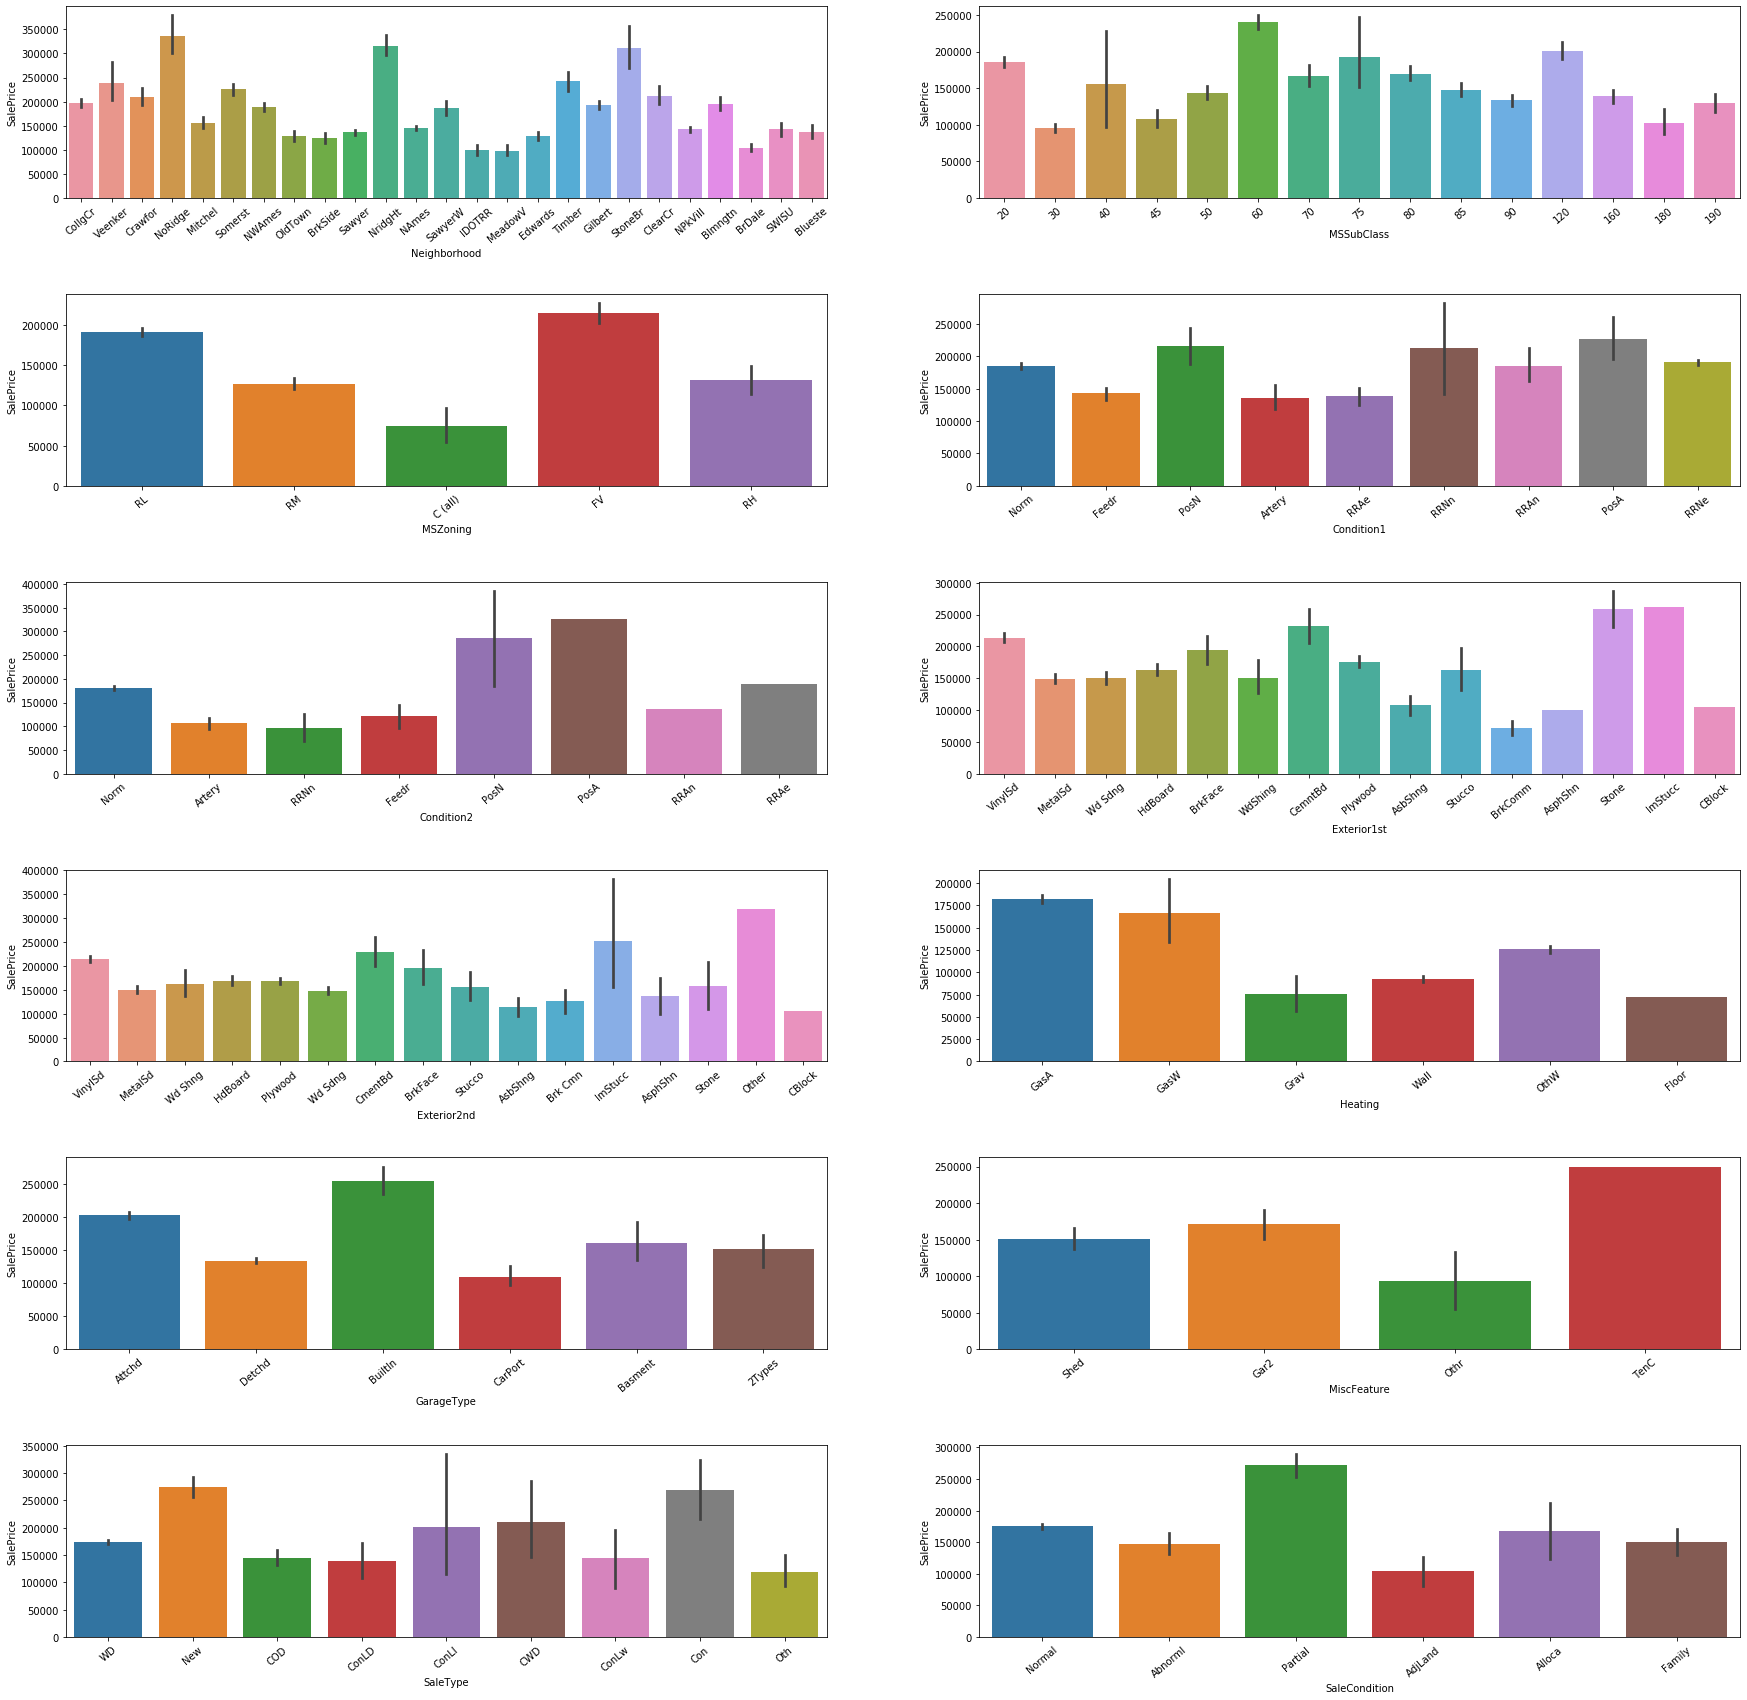

In [3]:
%matplotlib inline
fig1, axs1 = plt.subplots(ncols=2, nrows = 6, figsize=(30,30))
for ax in fig1.axes:
    plt.sca(ax)
    plt.xticks(rotation=40)
fig1.subplots_adjust(wspace=0.2, hspace=0.5)
sns.barplot(x='Neighborhood', y='SalePrice', data=df_train, ax=axs1[0][0]) 
sns.barplot(x='MSSubClass', y='SalePrice', data=df_train, ax=axs1[0][1])
sns.barplot(x='MSZoning',y='SalePrice', data=df_train, ax=axs1[1][0])
sns.barplot(x='Condition1', y='SalePrice', data=df_train, ax=axs1[1][1])
sns.barplot(x='Condition2', y='SalePrice', data=df_train, ax=axs1[2][0])
sns.barplot(x='Exterior1st',y='SalePrice', data=df_train, ax=axs1[2][1])
sns.barplot(x='Exterior2nd', y='SalePrice', data=df_train, ax=axs1[3][0])
sns.barplot(x='Heating', y='SalePrice', data=df_train, ax=axs1[3][1])
sns.barplot(x='GarageType',y='SalePrice', data=df_train, ax=axs1[4][0])
sns.barplot(x='MiscFeature', y='SalePrice', data=df_train, ax=axs1[4][1])
sns.barplot(x='SaleType', y='SalePrice', data=df_train, ax=axs1[5][0])
sns.barplot(x='SaleCondition',y='SalePrice', data=df_train, ax=axs1[5][1])

<b>Let's see</b>
<ul>
<li> Well the Neighborhoods Noridge, Nridght and StoneBr are the most expensive they surely have a starbucks and a yoga club.</li>

<li>The partial payment is more expensive because it is a partial payment that it is expensive or it is the houses that are expensive then the buyers are obliged to pay partially? Hmm ... you know what, I will wait for the sherlock's notebook I will have answers.</li>

<li>The Floating Village Residential and Residential Low Density are the most expensive, people love peace and be at the lake.</li>
</ul>

<b>Relationship with numerical variables</b>

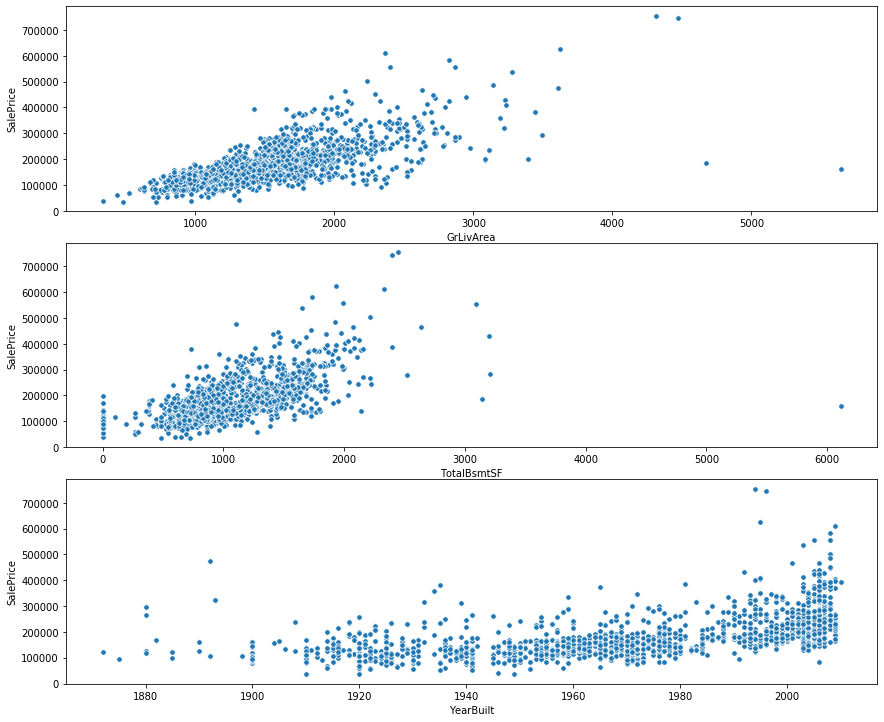

In [4]:
%matplotlib inline
# sns.set(font_scale=2)
# sns.set_context("paper", rc={"font.size":10,"axes.titlesize":10,"axes.labelsize":10}) 
fig2, axs2 = plt.subplots(ncols=1, nrows = 3, figsize=(12,10))
fig2.tight_layout()
# axs.tick_params(labelrotation=45)
sns.scatterplot(x='GrLivArea',y='SalePrice', data=df_train, ax=axs2[0], s=30)
sns.scatterplot(x='TotalBsmtSF', y='SalePrice', data=df_train, ax=axs2[1], s=30)
sns.scatterplot(x='YearBuilt', y='SalePrice', data=df_train, ax=axs2[2], s=30)

There is a positive linear relation between living area size, basement area size and Original construction date. 
Normal i want to say, the bigger the house is and the more nine are price increases.

<b>Correlation between values and SalePrice</b>

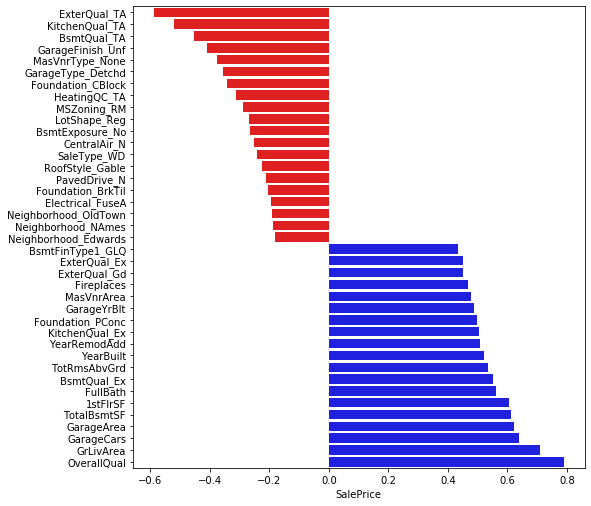

In [5]:
tmp = pd.get_dummies(df_train)
scaler = StandardScaler()
dummie_df = pd.DataFrame(scaler.fit_transform(tmp), columns = tmp.columns)
corr = dummie_df.corr()['SalePrice']
df_corr = pd.DataFrame(corr.sort_values().iloc[np.r_[0:20, -20:0]].drop('SalePrice'))
custom_palette = {}
for q , a in df_corr.iterrows():
    if a.values < 0:
        custom_palette[q] = 'r'
    else:
        custom_palette[q] = 'b'

fig3, ax3 = plt.subplots(figsize=(7, 7))
fig3.tight_layout()
sns.barplot(x="SalePrice",y = df_corr.index, data=df_corr,
            label="Correlation", palette=custom_palette, ax=ax3)

There is a strong negative correlation between the selling price and Average quality of the material on the exterior, Kitchen quality and the height of the basement.

And there is a strong positive relationship between the selling price and Rates the overall material and finish of the house, size of living area and size of garage in car capacity.

Why does an average quality influence the price negatively more than a mediocre quality?

We can rely on the positive correlation but on the negative one.

Maybe the number of houses with average quality is more important than others? lets check.

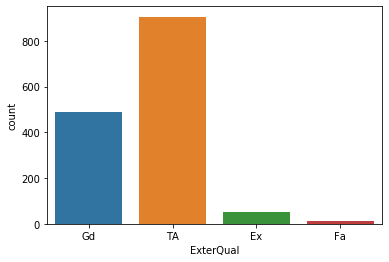

In [6]:
sns.countplot(x="ExterQual", data=df_train)

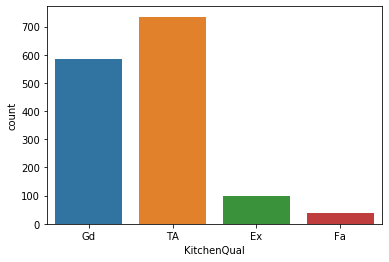

In [7]:
sns.countplot(x="KitchenQual", data=df_train)

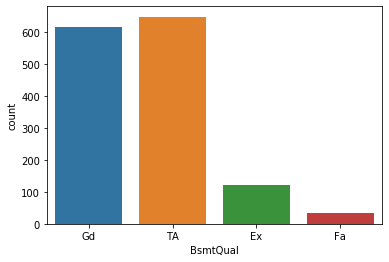

In [8]:
sns.countplot(x="BsmtQual", data=df_train)

Everything is explained, the TA values are more numerous than the other values, the union is the strength.

<b>Missing values</b>

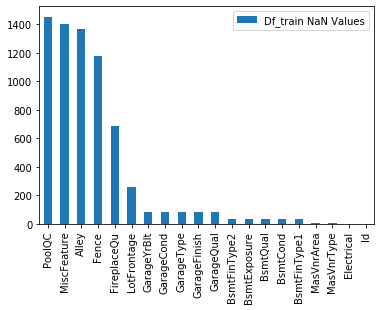

In [9]:
pd.DataFrame(df_train.isna().sum(), columns = ['Df_train NaN Values']).sort_values(by='Df_train NaN Values', ascending = False).head(20).plot(kind = 'bar')

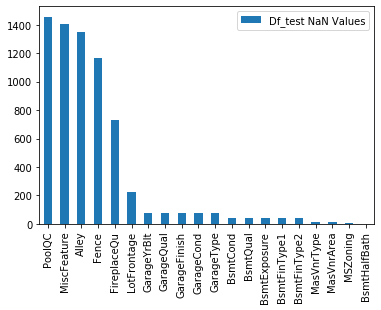

In [10]:
pd.DataFrame(df_test.isna().sum(), columns = ['Df_test NaN Values']).sort_values(by='Df_test NaN Values', ascending = False).head(20).plot(kind = 'bar')

There are many NaN values that I have to deal with later

<b>Correlation matrix (heatmap style)</b>

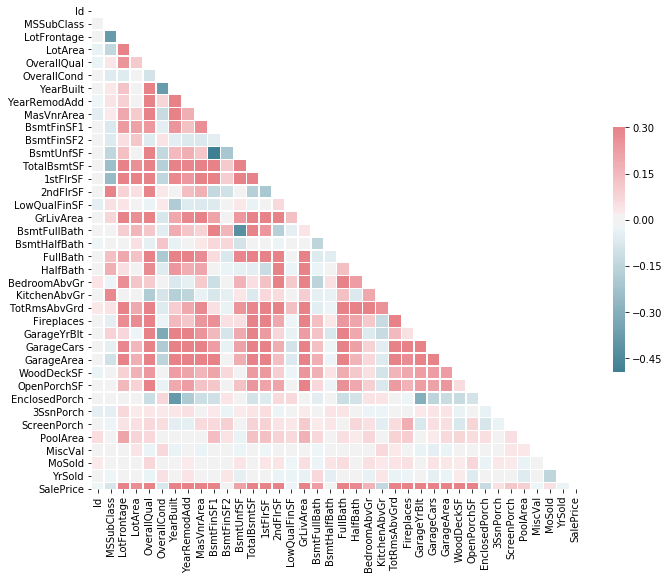

In [11]:
corr = df_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

A red square that interests me is the positive correlation between total square feet of basement area and size of garage in car capacity.
I can deduce that the garage can be part of the basement because the bigger it is, the larger the area of the basement is important.

Another red square that may be interesting is the positive correlation between Year garage was built and Size of garage in square feet.
Ae can say that over time people have more cars and cars have become bigger, by conceiving the size of the garage is more important and greenhouse gas production too and it's not good for nature Well, that's not the subject. protect nature =).

Aoncerning the blue squares there are two that have the darkest color.

The strong negative correlation between the original construction date, the people are disinterested porches in their houses and the new architchtures of houses do not include porches, it is old.

Concerning the blue squares there are two that have the darkest color.

The strong negative correlation between the original construction date, the people are disinterested porches in their houses and the new architchtures of houses do not include porches, it is old.

Another strong negative correlation between Unfinished square feet of basement area and Type 1 finished square feet, it is very logical the two features are oposed and contradictory.

There is still much to say but if talk about everything it will not be a notebook but a parchment.

<b>Resizing and viewing</b>

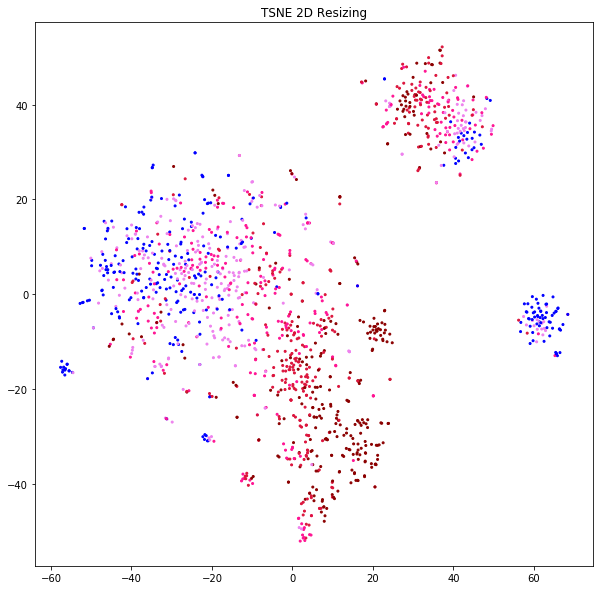

In [12]:
tmp2 = pd.get_dummies(df_train)
scaler2 = StandardScaler()
dummie_df2 = pd.DataFrame(scaler2.fit_transform(tmp2), columns = tmp2.columns)
X = dummie_df2.loc[:, dummie_df2.columns != 'SalePrice']
Y = dummie_df2.loc[:, dummie_df2.columns == 'SalePrice']
X['LotFrontage'].fillna(60.0, inplace = True)
X['GarageYrBlt'].fillna(1890.0, inplace = True)
X['MasVnrArea'].fillna(0, inplace = True)
tsne = TSNE(n_components = 2, perplexity = 30).fit_transform(X)

result_f = pd.DataFrame(tsne)
color = pd.qcut(Y['SalePrice'],5,labels=False).map({0 : 'blue' , 1 : 'violet' , 2: 'deeppink', 3 : 'crimson', 4: 'darkred'})
# color= ['red' if row == 'test' else 'blue' for row in output]
plt.figure(figsize=(10,10))
plt.title('TSNE 2D Resizing')
plt.scatter(result_f[0],result_f[1], s=4, c=color)
plt.show()

The scatter plot represents a resizing of the test data in two dimentions with a color nuanced compared to the sale price to see the attribution of the information.

Through graph we can see that there are 3 clusters of points, it may be interesting for clustring but it is a regression = /.

We can also see that the arrangement of colors differs, where there is blue there is not much darkred and where there is pink there is not much purple etc. As if there is an intensification of the blue color towards the darkred in a specific direction.

This is good news because it means that there is something that sets the prices high and low.

We can distinguish divergent points, it means that there are outliers that I have to deal with later

### Data Engineering

Lets prepar data fo ML.

The data preprocess that I have done is based on my own logic, a case that I will mention with a comment.

In this part I will deal with the missing values and transform the categorical values and add some features that I found useful.

In [13]:
df_test['SalePrice'] = 'test'
df = pd.concat([df_train, df_test])
df.drop(['Id'], axis=1, inplace = True)

In [14]:
df['PoolQC'].fillna('No Pool', inplace = True)
df['MiscFeature'].fillna('None', inplace = True)
df['Alley'].fillna('No alley access', inplace = True)
df['Fence'].fillna('No Fence', inplace = True)
df['FireplaceQu'].fillna('No Fireplace', inplace = True)
df['LotFrontage'].fillna(60.0, inplace = True)
df['GarageCond'].fillna('No Garage', inplace = True)
df['GarageType'].fillna('No Garage', inplace = True)
df['GarageYrBlt'].fillna(1890, inplace = True)
df['GarageFinish'].fillna('No Garage', inplace = True)
df['GarageQual'].fillna('No Garage', inplace = True)
df['BsmtExposure'].fillna('No Basement', inplace = True)
df['BsmtFinType2'].fillna('No Basement', inplace = True)
df['BsmtFinType1'].fillna('No Basement', inplace = True)
df['BsmtCond'].fillna('No Basement', inplace = True)
df['BsmtQual'].fillna('No Basement', inplace = True)
df['MasVnrArea'].fillna(0, inplace = True)
df['MasVnrType'].fillna('None', inplace = True)
# df['Exterior2nd'].fillna('None', inplace = True)
# df['Exterior1st'].fillna('None', inplace = True)
df['BsmtFullBath'].fillna(0, inplace = True) # df[df['BsmtFullBath'].isna()][['BsmtFullBath','BsmtFinType1','BsmtFinType2']]
df['BsmtHalfBath'].fillna(0, inplace = True) # df[df['BsmtFullBath'].isna()][['BsmtFullBath','BsmtFinType1','BsmtFinType2']]
# df['KitchenQual'].fillna(0, inplace = True)
  # df[(df['Neighborhood']== 'IDOTRR') | (df['Neighborhood']== 'Mitchel')]['MSZoning']
df.loc[(df['MSZoning'].isna()) & (df['Neighborhood'] == 'IDOTRR'), 'MSZoning'] = 'RM'
df.loc[(df['MSZoning'].isna()) & (df['Neighborhood'] == 'Mitchel'), 'MSZoning'] = 'RL'
df['Utilities'].fillna('AllPub', inplace = True) #la majorité
# df['BsmtHalfBath'].fillna(0.0, inplace = True) #la majorité
# df['BsmtFullBath'].fillna(0.0, inplace = True)
df['Functional'].fillna('Typ', inplace = True)
df['Exterior1st'].fillna('VinylSd', inplace = True)
df['Exterior2nd'].fillna('VinylSd', inplace = True)
df['TotalBsmtSF'].fillna(0, inplace = True)
df['BsmtUnfSF'].fillna(0, inplace = True)
df['BsmtFinSF2'].fillna(0, inplace = True)
df['GarageArea'].fillna(0, inplace = True)
df['GarageCars'].fillna(0, inplace = True)
df['KitchenQual'].fillna('TA', inplace = True)
df['BsmtFinSF1'].fillna(0, inplace = True)
df['SaleType'].fillna('WD', inplace = True)
df['Electrical'].fillna('SBrkr', inplace = True)
df['MSSubClass'] = df['MSSubClass'].astype(str)
df['OverallCond'] = df['OverallCond'].astype(str)

df['BsmtExposure'] = df['BsmtExposure'].map({'No Basement' : 0 ,'No' : 1, 'Mn' : 2, 'Av' : 3, 'Gd' : 4})
df['KitchenQual'] = df['KitchenQual'].map({'Po' : 0 ,'Fa' : 1, 'TA' : 2, 'Gd' : 3, 'Ex' : 4})

df['GarageYrBlt_Years'] =  abs(1890.0 - df['GarageYrBlt'])
df['YearBuilt_Years'] = abs(1872.0 - df['YearBuilt'])
df['GarageYrBlt'] = df['GarageYrBlt'].astype(str)
df['YearBuilt'] = df['YearBuilt'].astype(str)

tmp = df['MoSold'].map({ 1: 0.0833, 2: 0.1666, 3: 0.25, 4: 0.3333, 5: 0.4166, 6: 0.50, 7: 0.5833, 8: 0.6666, 9: 0.75, 10: 0.8333
      , 11: 0.9166
      , 12: 0.9999})
df['YearSold'] = abs(2006.0 - (df['YrSold'] + tmp)).astype(float)
df['MoSold'] = df['MoSold'].astype(str)
df['YrSold'] = df['YrSold'].astype(str)

criteria = [df['YearRemodAdd'] == df['YearBuilt'], df['YearRemodAdd'] != df['YearBuilt']]
values = [0, 1]

df['Remod'] = np.select(criteria, values, 0)
df['YearRemod'] = (df['YearRemodAdd'].astype(int) - df['YearBuilt'].astype(int)).astype(int)
df['YearRemodAdd'] = df['YearRemodAdd'].astype(str)
df['YearBuilt'] = df['YearBuilt'].astype(str)

df['Street'] = df['Street'].map({'Grvl': 0, 'Pave' : 1})
df['Alley'] = df['Alley'].map({'Grvl': 1, 'Pave' : 2 , 'No alley access' : 0 })
df['LotShape'] = df['LotShape'].map({'IR3': 0, 'IR2' : 1 , 'IR1' : 2 , 'Reg' : 3})
df['LandContour'] = df['LandContour'].map({'Low': 0, 'HLS' : 1 , 'Bnk' : 2 , 'Lvl' : 3})
df['Utilities'] = df['Utilities'].map({'ELO': 0, 'NoSeWa' : 1 , 'NoSewr' : 2 , 'AllPub' : 3})
# df['LotConfig'] = df['LotConfig'].map({'ELO': 0, 'NoSeWa' : 1 , 'NoSewr' : 2 , 'AllPub' : 3})
df['LandSlope'] = df['LandSlope'].map({'Gtl': 2, 'Mod' : 1 , 'Sev' : 0})

criteria = [
#AA
((df['Condition1'] == 'Artery') | (df['Condition1'] == 'RRAn') | (df['Condition1'] == 'PosA') | (df['Condition1'] == 'RRAe'))
&
((df['Condition2'] == 'Artery') | (df['Condition2'] == 'RRAn') | (df['Condition2'] == 'PosA') | (df['Condition2'] == 'RRAe'))
,
#AB
((df['Condition1'] == 'Artery') | (df['Condition1'] == 'RRAn') | (df['Condition1'] == 'PosA') | (df['Condition1'] == 'RRAe'))
&
((df['Condition2'] == 'Feedr') | (df['Condition2'] == 'RRNn') | (df['Condition2'] == 'PosN') | (df['Condition2'] == 'RRNe'))
,
#BA
((df['Condition2'] == 'Artery') | (df['Condition2'] == 'RRAn') | (df['Condition2'] == 'PosA') | (df['Condition2'] == 'RRAe'))
&
((df['Condition1'] == 'Feedr') | (df['Condition1'] == 'RRNn') | (df['Condition1'] == 'PosN') | (df['Condition1'] == 'RRNe'))
,
#BB
((df['Condition1'] == 'Feedr') | (df['Condition1'] == 'RRNn') | (df['Condition1'] == 'PosN') | (df['Condition1'] == 'RRNe'))
&
((df['Condition2'] == 'Feedr') | (df['Condition2'] == 'RRNn') | (df['Condition2'] == 'PosN') | (df['Condition2'] == 'RRNe'))
,
#A0
((df['Condition1'] == 'Artery') | (df['Condition1'] == 'RRAn') | (df['Condition1'] == 'PosA') | (df['Condition1'] == 'RRAe'))
&
(df['Condition2'] == 'Norm')
,
#0A
((df['Condition2'] == 'Artery') | (df['Condition2'] == 'RRAn') | (df['Condition2'] == 'PosA') | (df['Condition2'] == 'RRAe'))
&
(df['Condition1'] == 'Norm' )
,
#B0
((df['Condition1'] == 'Feedr') | (df['Condition1'] == 'RRNn') | (df['Condition1'] == 'PosN') | (df['Condition1'] == 'RRNe'))
&
(df['Condition2'] == 'Norm' )
,
#0B
((df['Condition2'] == 'Feedr') | (df['Condition2'] == 'RRNn') | (df['Condition2'] == 'PosN') | (df['Condition2'] == 'RRNe'))
&
(df['Condition1'] == 'Norm')
,
#00
(df['Condition1'] == 'Norm' )
&
(df['Condition2'] == 'Norm' )
]

values = [4,3,3,2,2,2,1,1,0]
df['conditions'] = np.select(criteria, values, 10)

df['Exterior2nd'] = df['Exterior2nd'].map({ 'AsbShng': 'AsbShng', 'AsphShn': 'AsphShn', 'Brk Cmn': 'BrkComm', 'BrkFace': 'BrkFace', 'CBlock': 'CBlock', 'CmentBd': 'CemntBd',
                       'HdBoard': 'HdBoard', 'ImStucc': 'ImStucc', 'MetalSd': 'MetalSd', 'Plywood': 'Plywood'
                      , 'Stone': 'Stone'
                      , 'Stucco': 'Stucco'
                      ,'VinylSd': 'VinylSd'
                      ,'Wd Sdng': 'Wd Sdng'
                      ,'Wd Shng': 'WdShing'
                      , 'None'  : 'None'
                      , 'Other' :  'Other'})

criteria = [
# Only 1
((df['Exterior1st'] == df['Exterior2nd']) | (df['Exterior2nd'] !=  'Other'))
,
# No One
(df['Exterior1st'] == 'None') &  (df['Exterior2nd'] == 'None')
,
# 2
(df['Exterior1st'] !=  df['Exterior2nd']) 
]

values = [1,0,2]
df['Exterior'] = np.select(criteria, values, 10)

criteria = [
# Have veneer 
(df['MasVnrType'] != 'None')
,
# Havnt veneer    
(df['MasVnrType'] == 'None')
]

values = [1,0]
df['veneer'] = np.select(criteria, values, 10)

df['ExterQual'] = df['ExterQual'].map({'Po' : 0 ,'Fa' : 1, 'TA' : 2, 'Gd' : 3, 'Ex' : 4})

df['ExterCond'] = df['ExterCond'].map({'Po' : 0 ,'Fa' : 1, 'TA' : 2, 'Gd' : 3, 'Ex' : 4})

df['BsmtQual'] = df['BsmtQual'].map({'No Basement' : 0 ,'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5})

df['BsmtFinType1'] = df['BsmtFinType1'].map({'No Basement' : 0 ,'Unf' : 1, 'LwQ' : 2, 'Rec' : 3, 'BLQ' : 4, 'ALQ' : 5, 'GLQ': 6})

df['BsmtFinType2'] = df['BsmtFinType2'].map({'No Basement' : 0 ,'Unf' : 1, 'LwQ' : 2, 'Rec' : 3, 'BLQ' : 4, 'ALQ' : 5, 'GLQ': 6})

criteria = [
# No Bsmt
(df['BsmtFinType1'] == 0) & (df['BsmtFinType2'] == 0)
,
# 1 Bsmt   
((df['BsmtFinType1'] != 0) & (df['BsmtFinType2'] != 0) & (df['BsmtFinType1'] == df['BsmtFinType2']))
|
((df['BsmtFinType1'] != 0) & (df['BsmtFinType2'] == 0))
|
((df['BsmtFinType1'] == 0) & (df['BsmtFinType2'] != 0)) 
,
# 2 bsmnt
(df['BsmtFinType1'] != 0) & (df['BsmtFinType2'] != 0) & (df['BsmtFinType1'] != df['BsmtFinType2'])
]

values = [0,1,2]
df['Bsmt'] = np.select(criteria, values, 10)

df['HeatingQC'] = df['HeatingQC'].map({'Po' : 0 ,'Fa' : 1, 'TA' : 2, 'Gd' : 3, 'Ex' : 4})

df['CentralAir'] = df['CentralAir'].map({'N' : 0 ,'Y' : 1})

df['FireplaceQu'] = df['FireplaceQu'].map({'No Fireplace' : 0 ,'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4 , 'Ex' : 5})

df['Functional'] = df['Functional'].map({'Sal' : 0 ,'Sev' : 1, 'Maj2' : 2, 'Maj1' : 3, 'Mod' : 4 , 'Min2' : 5, 'Min1' : 6, 'Typ' : 7})

criteria = [
# No garage
df['GarageType'] == 'No Garage'
,
#2 garages
df['GarageType'] == '2Types'
,
# only one garage
(df['GarageType'] != '2Types') & (df['GarageType'] != 'No Garage')
]

values = [0,2,1]
df['Garage'] = np.select(criteria, values, 10)

df['GarageFinish'] = df['GarageFinish'].map({'No Garage' : 0 ,'Unf' : 1, 'RFn' : 2, 'Fin' : 3})

df['GarageQual'] = df['GarageQual'].map({'No Garage' : 0 ,'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4 , 'Ex' :5})

df['GarageCond'] = df['GarageCond'].map({'No Garage' : 0 ,'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4 , 'Ex' :5})

df['PavedDrive'] = df['PavedDrive'].map({'N' : 0 ,'P' : 1, 'Y' : 2})

df['PoolQC'] = df['PoolQC'].map({'No Pool' : 0 ,'Fa' : 1, 'TA' : 2, 'Gd' : 3, 'Ex' : 4})

df['Fence'] = df['Fence'].map({'No Fence' : 0 ,'MnWw' : 1, 'GdWo' : 2, 'MnPrv' : 3, 'GdPrv' : 4})

criteria = [
# No Feature
df['MiscFeature'] == 'None'
,
# with Feature
df['MiscFeature'] != 'None'
]
values = [0,1]
df['Feature'] = np.select(criteria, values, 10)
df['TotalArea'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'] + df['GrLivArea'] +df['GarageArea']
df['Bathrooms'] = df['FullBath'] + df['HalfBath']*0.5 
df['Year average']= (df['YearRemodAdd'].astype(int)+df['YearBuilt'].astype(int))/2



In this part I keep the common columns between the test and the train and I delete the outliers in the train data.

In [15]:
df_train = df[df['SalePrice'] != 'test']
df_test = df[df['SalePrice'] == 'test']
df_train['SalePrice'] = df_train['SalePrice'].astype(float)

# to reduce the skewness of the saleprice it is necessary to apply the logarithm function on the saleprice. 
# More details are on this notebook: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
df_train['SalePrice'] =  np.log1p(df_train['SalePrice'])

In [16]:
scaler1 = StandardScaler()
df_test.drop(['SalePrice'], axis = 1, inplace = True)
dum =  pd.get_dummies(df_train, drop_first  = True)
dum_test =  pd.get_dummies(df_test, drop_first  = True)

dum1 = dum.copy()
dum_test1 = dum_test.copy()
col = []
for i in dum.columns:
    if i not in dum_test.columns :
        col.append(i)
        
for i in dum_test.columns:
    if i not in dum.columns :
        col.append(i)
        
for i in dum1.columns:
    if i in col :
        dum1.drop(i, axis = 1, inplace = True)
for i in dum_test1.columns:
    if i in col :
        dum_test1.drop(i, axis = 1, inplace = True)

In [17]:
x = scaler1.fit_transform(dum1)

knn = KNN()
outliers = knn.fit_predict(x)

In [18]:
dum1['outliers_flag'] = outliers
dum1['SalePrice'] = df_train['SalePrice']

final_outlier = dum1[dum1.outliers_flag != 1]
X = final_outlier.loc[:, final_outlier.columns != 'outliers_flag']
X = X.loc[:, X.columns != 'SalePrice']
y = final_outlier['SalePrice']

pca = PCA(n_components=2)
X['pca1'] =  pd.DataFrame(pca.fit_transform(pd.DataFrame(X)))[0].tolist()
X['pca2'] =  pd.DataFrame(pca.fit_transform(pd.DataFrame(X)))[1].tolist()

### Machine Learning

I took several classification algorithm and I compared their RMSE on the train data in cross validation.

In [19]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X)
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

model_xgb = make_pipeline(RobustScaler(),xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1))
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = make_pipeline(RobustScaler(),KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5))
GBoost = make_pipeline(RobustScaler(),GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5))
RFR = make_pipeline(RobustScaler(),RandomForestRegressor(random_state = 1))
Ridge = make_pipeline(RobustScaler(),Ridge(alpha = 17))
lr = make_pipeline(RobustScaler(),LinearRegression())
ex_reg=make_pipeline(RobustScaler(),ExtraTreesRegressor(n_estimators=2000, max_depth=20))
svr = make_pipeline(RobustScaler(),SVR(kernel='rbf',C=20000,gamma=0.045))

In [20]:
scores = {}
score = rmsle_cv(model_xgb)
scores['Xgboost'] = score.mean()
score = rmsle_cv(lasso)
scores['Lasso'] = score.mean()
score = rmsle_cv(ENet)
scores['ElasticNet'] = score.mean()
score = rmsle_cv(KRR)
scores['Kernel Ridge'] = score.mean()
score = rmsle_cv(GBoost)
scores['Gradient Boosting'] = score.mean()
score = rmsle_cv(RFR)
scores['Random Forest'] = score.mean()
score = rmsle_cv(Ridge)
scores['Ridge'] = score.mean()
score = rmsle_cv(lr)
scores['lr'] = score.mean()
score = rmsle_cv(ex_reg)
scores['svr'] = score.mean()
score = rmsle_cv(svr)
scores['svr'] = score.mean()

In [21]:
sorted(scores.items(), key=operator.itemgetter(1))

[('Lasso', 0.1100145720076218),
 ('ElasticNet', 0.11003107797204122),
 ('Ridge', 0.11074594439635463),
 ('Xgboost', 0.11552935613844131),
 ('Gradient Boosting', 0.11639389518409304),
 ('Kernel Ridge', 0.13439210269071206),
 ('Random Forest', 0.14145773328174685),
 ('svr', 0.25660769442292375),
 ('lr', 512.9875897144435)]

Lasso, ElasticNet, Ridge and Xgboost gave the best score, lets test voting on them.

In [32]:
vote_mod = make_pipeline(RobustScaler(),VotingRegressor([('Ridge', Ridge), ('Lasso', lasso), ('Elastic', ENet), ('Xgboost', model_xgb)]))

score = rmsle_cv(vote_mod)
print("vote_mod score: {:.4f} \n".format(score.mean()))

vote_mod score: 0.1083 



In [33]:
stregr = make_pipeline(RobustScaler(),StackingRegressor(regressors=[ENet,Ridge, lasso, vote_mod], 
                           meta_regressor=model_xgb, use_features_in_secondary=True))

score = rmsle_cv(stregr)
print("stregr score: {:.4f}\n".format(score.mean()))

stregr score: 0.1096



Voting and stacking have almost the same score, use blending between them and applying some adjustment to the result of the blending.

In [34]:
stregr.fit(X, y)
vote_mod.fit(X, y)

pca = PCA(n_components=2)
dum_test1['pca1'] =  pd.DataFrame(pca.fit_transform(pd.DataFrame(dum_test1)))[0].tolist()
dum_test1['pca2'] =  pd.DataFrame(pca.fit_transform(pd.DataFrame(dum_test1)))[1].tolist()

stack_predict  =  stregr.predict(dum_test1)
vote_pred  =  vote_mod.predict(dum_test1)

In [35]:
df_output['SalePrice'] = 0.7*np.expm1(vote_pred) + 0.3 * np.expm1(test_predict)

# source : https://www.kaggle.com/jesucristo/1-house-prices-solution-top-1

q1 = df_output['SalePrice'].quantile(0.0045)
q2 = df_output['SalePrice'].quantile(0.99)

df_output['SalePrice'] = df_output['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
df_output['SalePrice'] = df_output['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)

filename = 'submission.csv'

df_output.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: submission.csv


### Done !

I hope you enjoyed. If so, put an <b>Upvote!</b>

<img src="Gol D. Roger.jpg">